# Time Series Forecasting Multivariato con Bike Sharing Demand

### _Obiettivo del progetto:_
Predire la domanda futura di biciclette (prossima ora), usando una finestra temporale passata (ultime 24 ore) e le caratteristiche meteo e temporali.

Fonte: [kaggle.com](https://www.kaggle.com/competitions/bike-sharing-demand/data)

## Import delle librerie necessarie

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Import dataset

**Datetime** - hourly date + timestamp   
**Season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**Holiday** - whether the day is considered a holiday  
**Workingday** - whether the day is neither a weekend nor holiday   
**Weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy;
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist;
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds;
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**Temp** - temperature in Celsius   
**Atemp** - "feels like" temperature in Celsius   
**Humidity** - relative humidity   
**Windspeed** - wind speed   
**Casual** - number of non-registered user rentals initiated   
**Registered** - number of registered user rentals initiated   
**Count** - number of total rentals   

In [3]:
df = pd.read_csv("./data/raw/train.csv")
test_df = pd.read_csv("./data/raw/test.csv")

## Analisi dataset

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [7]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Preprocessing

In [8]:
# parsing datetime
df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df = df.drop(columns=["datetime"])


test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df["hour"] = test_df["datetime"].dt.hour
test_df["dayofweek"] = test_df["datetime"].dt.dayofweek
test_df["month"] = test_df["datetime"].dt.month
test_df["year"] = test_df["datetime"].dt.year
test_df = test_df.drop(columns=["datetime"])

In [9]:
# rimozione colonne ridondanti
df = df.drop(columns=["casual", "registered"])

In [10]:
# normalizzazione
from sklearn.preprocessing import StandardScaler

features = ["temp", "atemp", "humidity", "windspeed"]
scaler = StandardScaler()

df[features] = scaler.fit_transform(df[features])

test_df[features] = scaler.transform(test_df[features])

In [11]:
# suddivisione train/val temporale (ultimi 10%)
train_df = df.iloc[:int(len(df) * 0.9)]
val_df   = df.iloc[int(len(df) * 0.9):]

In [12]:
# salvataggio dataset processati
train_df.to_csv("data/processed/train.csv", index=False)
test_df.to_csv("data/processed/test.csv", index=False)
val_df.to_csv("data/processed/val.csv", index=False)

## Grafici esplorativi post-preprocessing

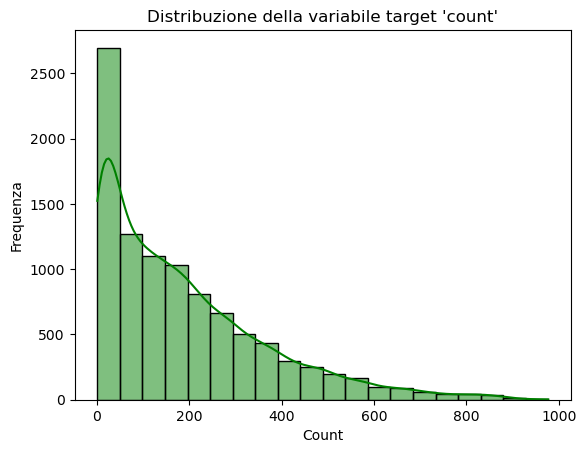

In [46]:
sns.histplot(data=train_df, x='count', kde=True, bins=20, color="green")
plt.title("Distribuzione della variabile target 'count'")
plt.xlabel("Count")
plt.ylabel("Frequenza")
plt.show()

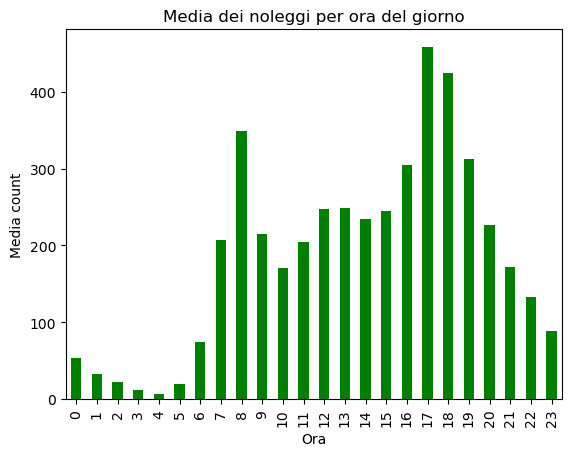

In [47]:
train_df.groupby("hour")["count"].mean().plot(kind='bar', color='green')
plt.title("Media dei noleggi per ora del giorno")
plt.xlabel("Ora")
plt.ylabel("Media count")
plt.show()

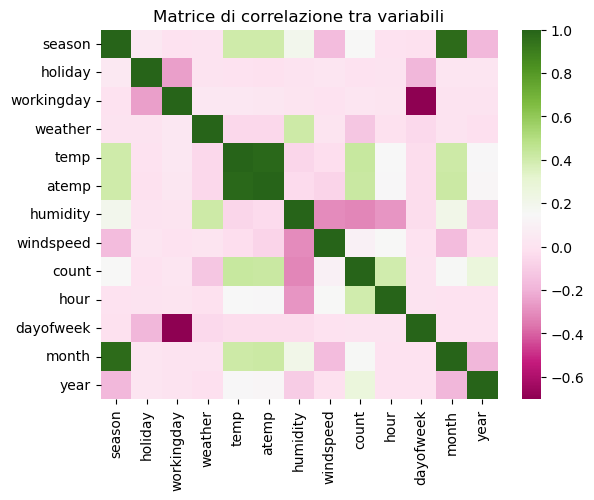

In [50]:
sns.heatmap(train_df.corr(), cmap='PiYG')
plt.title("Matrice di correlazione tra variabili")
plt.show()